# How Fast Can You Krige a Time Series?
## *A Numerical Experiment with Open-Source Libraries*

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# also, we should manually set the dpi for figures so they look good
# if saving figs, you should do so at a much higher dpi!
dpi = 300

## Recommended Reading

- Nargess Memarsadeghi et al., "Efficient kriging via fast matrix-vector products". In: 2008 IEEE Aerospace Conference (pp. 1-7), IEEE, 2008
- Hans Wackernagel, *Multivariate geostatistics: an introduction with applications*, third edition, Springer, 2003
- GSTools documentation: https://geostat-framework.readthedocs.io/projects/gstools/en/stable/
- SKLearn Docs on Gaussian Processes: https://scikit-learn.org/stable/auto_examples/gaussian_process/index.html 
- This online time series book by Alexander Aue at UC Davis covers some of the definitions we'll use: https://stats.libretexts.org/Bookshelves/Advanced_Statistics/Time_Series_Analysis_(Aue)/1%3A_Basic_Concepts_in_Time_Series/1.2%3A_Stationary_Time_Series
- After preparing this demo, I found the following paper which was written in the same spirit: https://www.sciencedirect.com/science/article/abs/pii/S0377221717308962?fr=RR-2&ref=pdf_download&rr=895ebf74ba6daaec

In this notebook, we perform some numerical experiments to compare the performance of various open-source routines for ordinary kriging/Gaussian process regression in the context of time series analysis. For theory background, see the books of Wackernagel or Aue mentioned under "recommended reading". Since kriging involves solving a linear system with a structured (but dense) matrix and multiple right-hand sides, there are many different numerical approaches one can use to krige. Here, the methods tested are...

1) Tikhonov regularization and a naive direct solve using Numpy (here, this is implemented "from scratch");
2) the Moore-Penrose pseudoinverse (implemented in the GSTools package);
3) fast multipole methods (FMM) used as in Memarsadeghi et al. to take advantage of the "kernel structure" of the matrix in question (implemented here using Frederik Beaujean's PyFigtree package https://github.com/fredRos/pyfigtree);
4) block MINRES (implemented in the very nice but unfortunately unmaintained krylov package by Nico Schlömer https://pypi.org/project/krylov/#description);
5) Tikhonov regularization and Cholesky decomposition (implemented in SciKit-Learn).

Through our experiments we find that the SciKit-Learn routines give the best overall performance in terms of estimator quality and speed. Surprisingly, the naive direct method using Numpy is a close second! Block MINRES is fast and decent at data smoothing but gives excessively small error bars, while the GSTools pseudoinversion method suffers either from insufficient smoothing or unacceptable slowness. Interestingly, despite FMM being the quickest method **on paper**, the PyFigtree implementation is far too slow to be useful in practice (often much slower than GSTools!) and gives an estimator with comparatively unremarkable performance.  

Additionally, we'll find that the variogram/kernel training is a performance issue: using GSTools gives much worse performance than SciKit-Learn both in terms of speed and in terms of final estimator quality (specifically, SciKit-Learn gives wider error bars that "explain" more of the data). 

So, if you don't want to read every detail, here's the takeaway: **use SciKit-Learn for kriging whenever possible**, at least until a better implementation of FMM comes along. 

We use synthetic data for our numerical experiments. We take a simple cosine function $z(t)$, sample it at 16,000 times, add some high-amplitude white noise, and only keep every 600 samples as training data. We then see how well each of our estimators can recover the ground truth $z(t)$ using only the training samples. 

In [2]:
num_pts = 16001
t = np.linspace(0,1, num=num_pts, endpoint=True)
np.random.seed(32) # fix random seed
R = np.random.normal(loc=0., scale=1., size=1)
phi = 0. 
omega = 0.5
z = R*np.cos(omega*2.*np.pi*t + phi) 
z_noisy = z + 0.2*np.random.randn(len(t))
sample_freq = 600
z_obs = z_noisy[::sample_freq]
t_obs = t[::sample_freq]

Let's plot the training data to see how much noise corrupts the ground truth: 

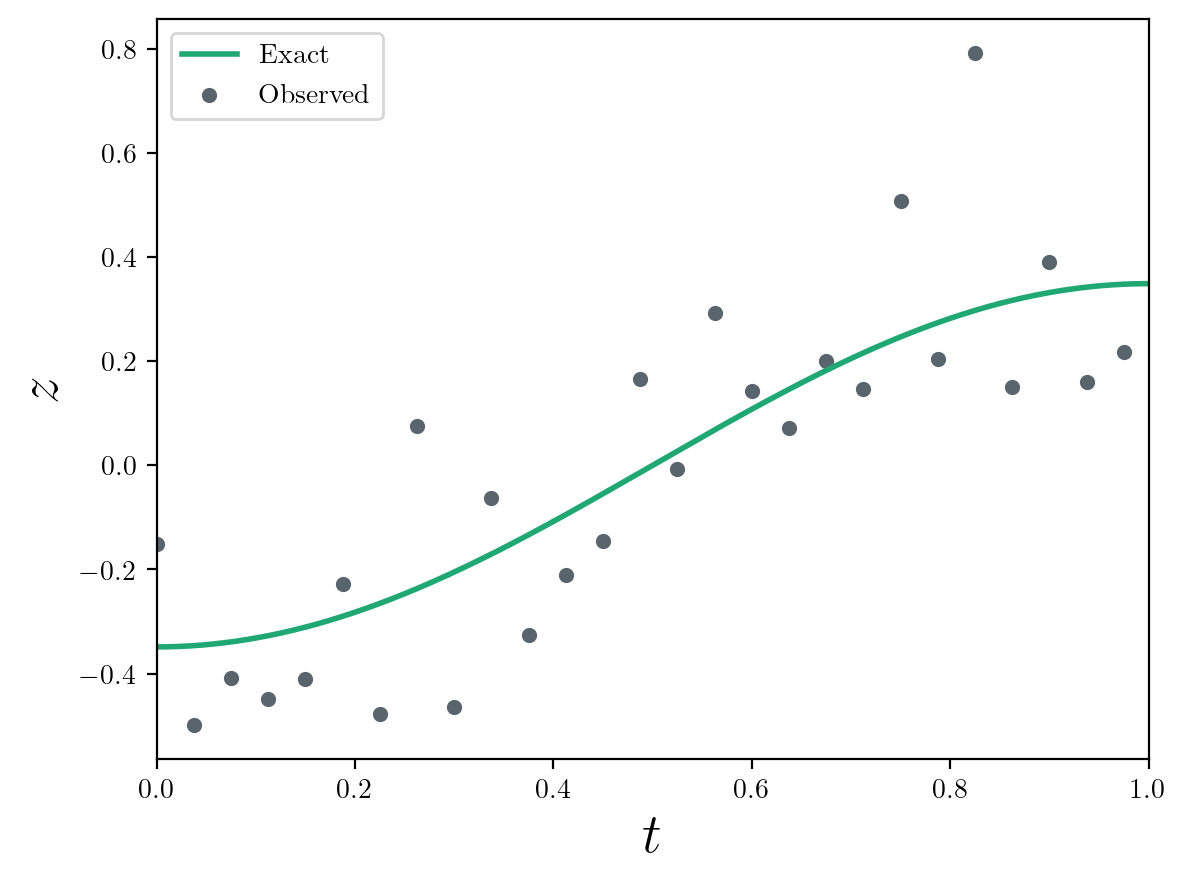

In [3]:
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

To perform kriging, we need to use the observations to train a Gaussian variogram (which in turn gives the covariance function of our random field/the autocorrelation function of our time series/however you want to say it!). For now, we use the GSTools variogram estimator to perform this function, but note that SciKit-Learn can directly give you the covariance function much faster (as we'll see later).  

In [4]:
import gstools as gs 

# Obtain the variogram using GSTools
start=time.time()
num_bins = int(num_pts/sample_freq)
bin_center, g = gs.vario_estimate(t_obs, z_obs, bin_edges = np.linspace(0,1,num=num_bins), estimator='matheron')
#plt.scatter(bin_center, g)
#plt.show()

In [5]:
fit_model = gs.Gaussian(dim=1)
para, pcov, r2 = fit_model.fit_variogram(bin_center, g, return_r2=True, nugget=False)
sigma = fit_model.var
L = fit_model.len_scale
end=time.time()
vg_fit_time = end-start
print('Variogram Estimation Time =', vg_fit_time,'s')
#fit_model.plot()
#plt.scatter(bin_center, g)
#plt.show()

Variogram Estimation Time = 0.008538246154785156 s


Since our training set is pretty small this time, the variogram is quick to construct. With much more data, however, GSTools really slows down. 

Let's check the variogram model GSTools spit out: 

In [6]:
print(fit_model)

Gaussian(dim=1, var=0.217, len_scale=0.361, nugget=0.0)


Since the covariance function, not the variogram, is what lets us set up the ordinary kriging system, let's extract the covariance function now: 

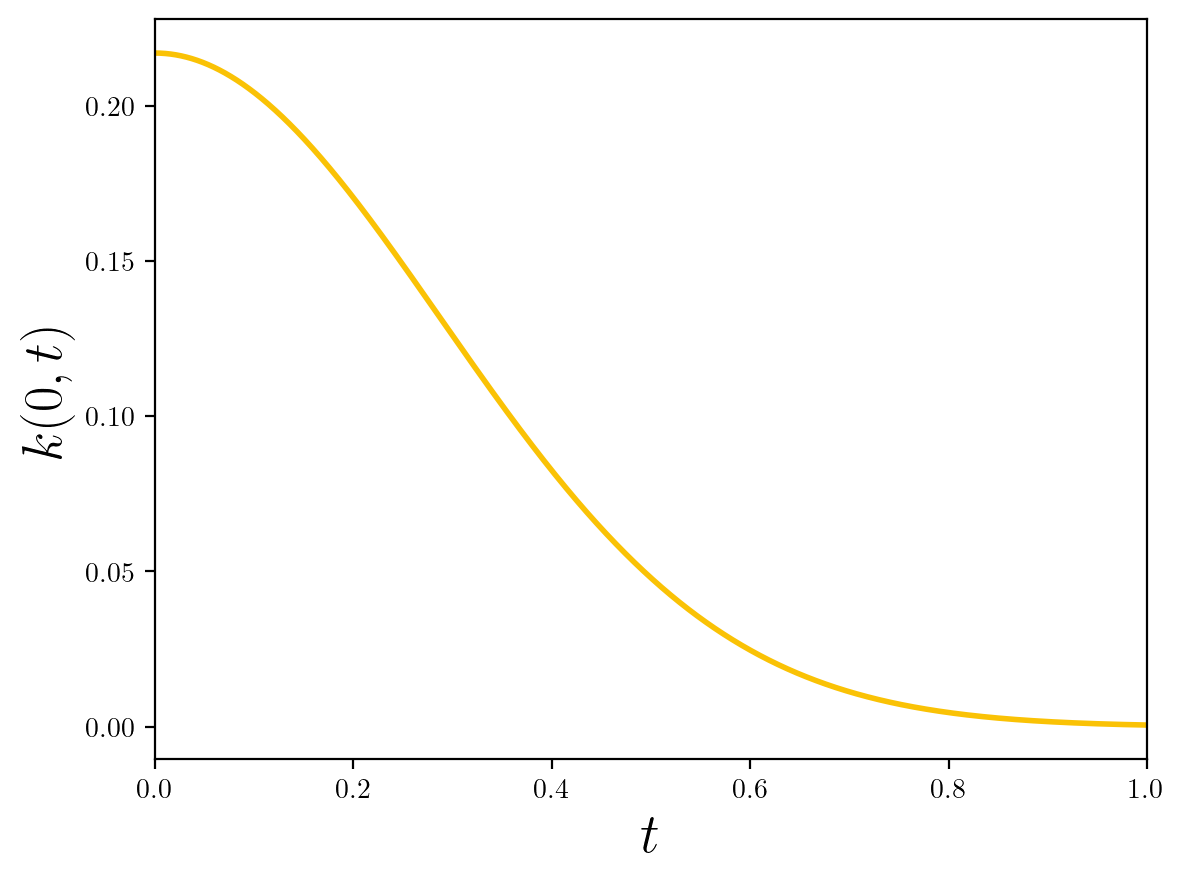

In [7]:
def k(s,t):
 return fit_model.covariance(s-t)

# and plot it to make sure the shape is doing what it should
plt.plot(t, k(0,t), color='xkcd:goldenrod', linewidth=2)
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$k(0,t)$', fontsize='20')
plt.xlim([0.,1.])
plt.show()

As we expect when training a Gaussian variogram, we get a little Gaussian bump in the above picture. This means that small times are more correlated with time $t=0$ than larger times, which is often a natural assumption. 

With the kernel at our disposal, elegantly assembling the Krige matrix is easy. 

In [8]:
def assemble_krige_matrix(k, t_obs):
    n = len(t_obs)
    K = np.ones((n+1, n+1), dtype='float')
    ss, tt = np.meshgrid(t_obs, t_obs)
    K[-1,-1] = 0.
    K[0:n, 0:n] = k(ss, tt) 
    return K
    
K = assemble_krige_matrix(k, t_obs)

To demonstrate why regularization is necessary even for simple problems, let's get the condition number of $K$ as well as the condition number of $K+\gamma I$ where $\gamma\in (0,1)$ is a small regularization parameter and $I$ is the identity matrix with the same shape as $K$:  

In [9]:
print(np.linalg.cond(K))
gamma = 1e-1 # Tikhonov regularization parameter
Khat = K + gamma * np.eye(len(t_obs)+1) 
Khat[-1,-1] = 0 
print(np.linalg.cond(Khat))

4.719763249288518e+19
71.49593564800622


So, even modest regularization fixes the problem of heinous conditioning. 

We can also get the right-hand sides of the kriging system, stored in a single array $b$. Each column of $b$ relates to a point where we want to predict the value of $z(t)$. 

In [10]:
t_pred=t

# generate an n x m matrix of right-hand sides 
def assemble_krige_rhs(k, t_obs, t_pred):
    n = len(t_obs)
    m = len(t_pred)
    b = np.ones((n+1, m), dtype='float')
    ss, tt = np.meshgrid(t_pred, t_obs)
    b[0:n, 0:m] = k(ss, tt) 
    return b
    
b = assemble_krige_rhs(k, t_obs, t_pred)

### Method 1: Naive Direct Solve w/ Numpy

For a first pass, let's just use Numpy's $\texttt{linalg.solve}$ to solve the problem: 

In [11]:
start=time.time()
my_soln = np.linalg.solve(Khat,b)
my_weights = my_soln[:-1,:]

In [12]:
my_z_pred = z_obs.T @ my_weights

In [13]:
end=time.time()
my_runtime = end-start
print('Homemade direct solve runtime = % .3f' % my_runtime, 's')

Homemade direct solve runtime =  0.006 s


That was fast! Let's check the unbiasedness constraint: 

In [14]:
print(np.sum(my_weights, axis=0))

[1. 1. 1. ... 1. 1. 1.]


So, the simplest method possible seems pretty good in terms of speed, and it at least gives an unbiased estimator. But can we reproduce the ground truth, or at least place the ground truth within the error bars of the estimator? Let's check now. 

First, let's write a general function that computes the standard deviation (error) of each kriging prediction. 

In [15]:
# get error estimates efficiently with the magic of einsum. Note how we can't use the standard kriging error formula
# here bcz we seldom have an exact soln to the ordinary kriging equations, so that formula no longer makes sense! 
def get_kriging_std(k, K, b, weights): # computes cost function 
    var = np.einsum('j..., ji , i...', weights, K[:-1,:-1], weights)-2.*np.einsum('j...,j...', weights, b[:-1]) + k(0,0)*np.ones_like(t_pred)
    var[var<0] = 0.
    out = np.sqrt(var)
    return out

my_std = get_kriging_std(k, K, b, my_weights)

Now, we plot the mean prediction (solution of the kriging system) with error estimates computed with the above code box. 

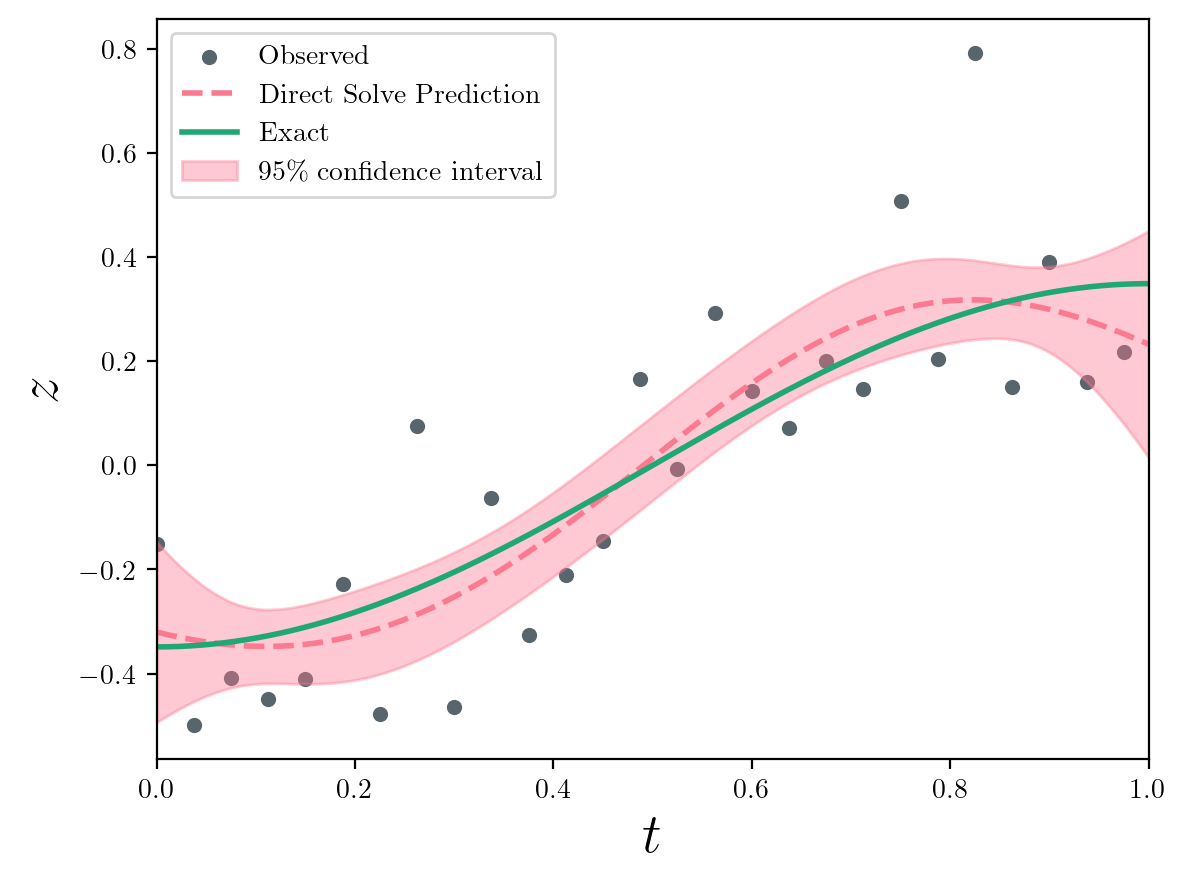

In [16]:
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.plot(t_pred, my_z_pred, linestyle='dashed', color = 'xkcd:carnation', linewidth='2', label='Direct Solve Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.fill_between(
    t_pred,
    my_z_pred - 1.96*my_std,
    my_z_pred + 1.96*my_std,
    alpha=0.4,
    label=r"95\% confidence interval",
    color='xkcd:carnation',
)
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

The estimated mean is pretty close to the ground truth, and the error bars seem decent (though they clearly don't "explain" even moderate outliers). So, naive kriging with Numpy and a bit of regularization is not bad at all. 

### Method 2: GSTools

Next, it's GSTools' turn. Instead of taking in the matrix $K$ and RHS $b$, GSTools' kriging function wants to take in our variogram model abd training data only.  

In [17]:
from gstools import krige
# the boolean "pseudo_inv" is True if we want regularization (a least-squares solution instead of an actual "solution") and False otherwise.
# if we accept a least-squares solution then kriging no longer gives an exact interpolator! 
start=time.time()
krig = krige.Ordinary(fit_model, cond_pos=t_obs, cond_val=z_obs, pseudo_inv = True)
t_pred = t
krig(t_pred); 
end=time.time()
gs_runtime= end-start
print('Homemade direct solve runtime = % .3f' % my_runtime, 's')
print('GSTools runtime = %.3f' % gs_runtime, 's')
gs_z_pred = krig[0];
gs_errors = krig[1];

Homemade direct solve runtime =  0.006 s
GSTools runtime = 0.012 s


This is way faster than method 1, but what kind of estimator do we get? 

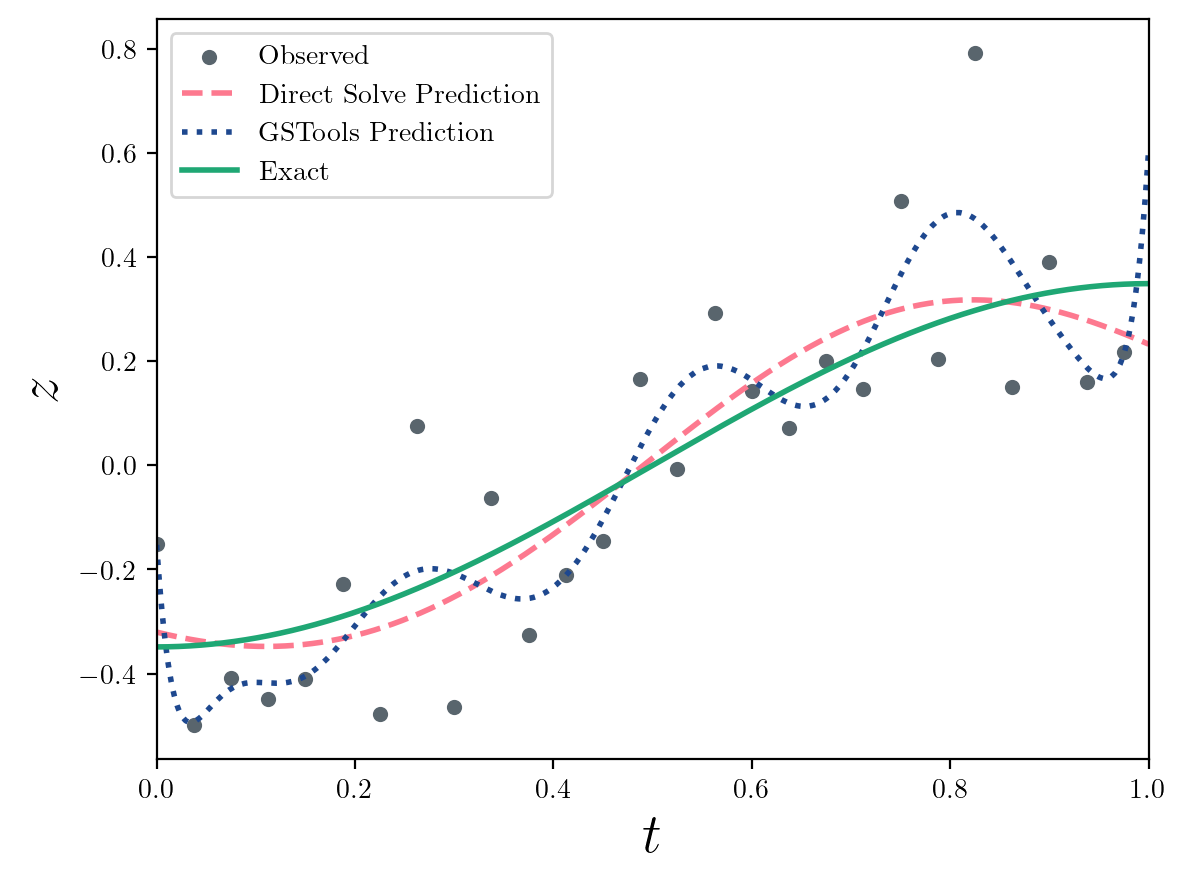

In [18]:
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.plot(t_pred, my_z_pred, linestyle='dashed', color = 'xkcd:carnation', linewidth='2', label='Direct Solve Prediction')
plt.plot(t_pred, gs_z_pred, color='xkcd:cobalt', linestyle='dotted',linewidth='2', label='GSTools Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

Yikes! GSTools did not smooth the training data enough to get close to the ground truth. While it's not as bad as overfitting, it's certainly a problem. Additionally, the error estimates produced by GSTools are far too small to explain *any* data: 

In [19]:
print(np.amax(gs_errors))

1.5124225665574809e-05


So, GSTools has a tougher time recovering the ground truth than even the basic homemade method. Further experiments with larger training sets convinced me that GSTools can also suffer from speed issues when it gives you a good estimator. 

Why does GSTools have these problems? First, it solves the kriging system by computing the pseudo-inverse of the kriging matrix $K$ (without regularization!) and multiplying each RHS (column of $b$) by this pseudo-inverse. This approach has two big issues. 

1) First, and most significantly, the dense matrix-vector multplications are costly and scale poorly both with the number of right-hand sides and the amount of training data.

2) Second, pseudo-inversion gives *some* regularization, but it's not easy for the user to tune how much regularization they get. Method 1, on the other hand, keeps the Tikhonov regularization parameter $\gamma$ flexible: if you don't see enough smoothing, crank $\gamma$ up and try again.

So, based on these issues, I'd recommend avoiding kriging with GSTools in favour of alternatives when possible. 

### Method 3: FMM with PyFigtree

Let's now try to solve the kriging system using FMM (specifically, the **improved fast Gauss transform** or **IFGT**) implemented in PyFigtree. We use PyFigtree to perform fast matrix-vector multiplications and SciPy's implementation of MINRES to perform the iterative solve. I chose to use this software instead of writing my own FMM code because 

1) writing FMM code is hard;

2) no, I mean it's really, really hard.

However, we'll find that even with some help from the joblib parallel-izer, PyFigtree has a lot of problems when it comes to kriging. 

In [20]:
from pyfigtree import figtree # IFGT library
import scipy.sparse.linalg as linalg
import joblib

n = len(z_obs)

h = 2.*fit_model.len_scale/np.sqrt(np.pi)

# define "fast" matrix-vector multiplication
def mv(v):

    out = np.zeros_like(v, dtype=float)
    
    # careful how the weights are defined here! 
    
    try: # compute in parallel (column-wise) if input is a matrix to avoid bad scaling of fgt with number of weights (PyFigtree will 
        # convert RHS into a really long array and try to FGT this, causing unacceptable slowdown)
        
        def fgt(j):
            return figtree(t_obs, t_obs, sigma*v[:-1,j].T, bandwidth=h, epsilon=1e-12)
    
        fgt = joblib.Parallel(n_jobs=-1)(joblib.delayed(fgt)(j) for j in range(num_pts)) 
        
    except IndexError: # if input is a vector just do it all at once
        
        fgt = figtree(t_obs, t_obs, sigma*v[:-1,...].T, bandwidth=h, epsilon=1e-12)


    out[:-1,...] = np.reshape(fgt, np.shape(v[:-1,...].T)).T + np.tensordot(np.ones(n, dtype=float),  v[-1,...], axes=0) #+ gamma*v[:-1] # if u want regularization, which you don't need
    
    out[n,...] = np.sum(v[:-1,...], axis=0)

    return out

linop = linalg.LinearOperator(shape=(n+1,n+1), matvec = mv, matmat = mv)

# to debug, we can test the implementation of the matrix-vector mult
#v = np.random.rand(n+1)
#print(np.amax(np.abs(K@v-mv(v))))

In [21]:
import joblib

start=time.time()
def ifgt_predict(j):
    return np.dot(z_obs, linalg.minres(linop, b[:,j], rtol = 1e-2, maxiter = 10, x0 =np.ones(n+1)/n)[0][:-1])
    
ifgt_z_pred = joblib.Parallel(n_jobs=-1)(joblib.delayed(ifgt_predict)(j) for j in range(num_pts)) 
end=time.time()
ifgt_runtime = end-start
print('Homemade direct solve runtime = % .3f' % my_runtime, 's')
print('GSTools runtime = %.3f' % gs_runtime, 's')
print('IFGT kriging runtime = %.3f' % ifgt_runtime, 's')

Homemade direct solve runtime =  0.006 s
GSTools runtime = 0.012 s
IFGT kriging runtime = 19.348 s


Unfortunately, even with joblib, the IFGT approach takes almost twenty seconds on my desktop! Does it at least give a good estimator? 

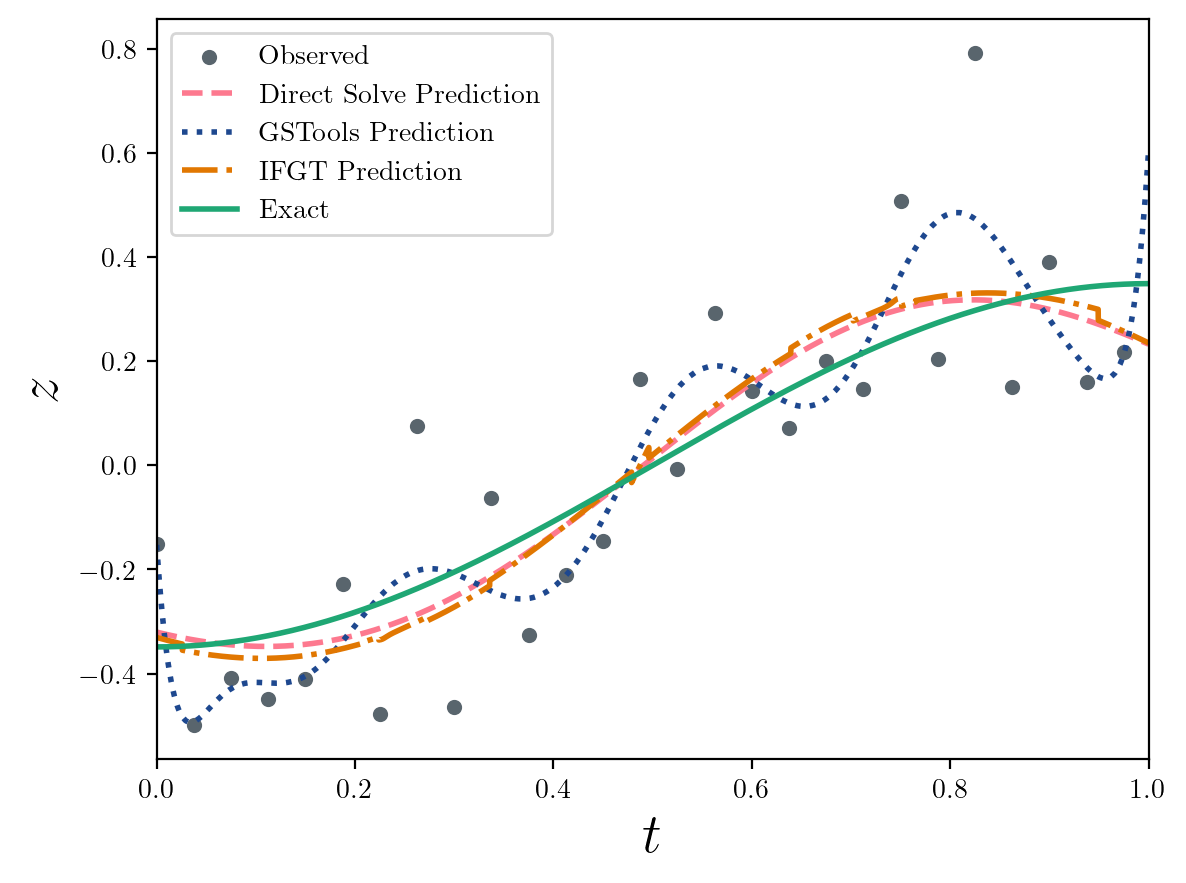

In [22]:
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.plot(t_pred, my_z_pred, linestyle='dashed', color = 'xkcd:carnation', linewidth='2', label='Direct Solve Prediction')
plt.plot(t_pred, gs_z_pred, color='xkcd:cobalt', linestyle='dotted',linewidth='2', label='GSTools Prediction')
plt.plot(t_pred, ifgt_z_pred, color='xkcd:pumpkin', linestyle='dashdot',linewidth='2', label='IFGT Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

So, IFGT means we wait over 40 times longer for an estimator that is pretty much as good as the trivially-implemented direct method. PyFigtree as it currently stands should never, therefore, be used in practice for kriging. 

### Method 4: Block MINRES

Next, we can try to approximately solve the system iteratively by using block MINRES (that is, MINRES adapted to deal with multiple right-hand sides). In my early experiments I found that MINRES iterations were very effective smoothers, so this approach seemed promising. 

In [23]:
import krylov #(https://pypi.org/project/krylov/#description)

start=time.time()
sol, info = krylov.minres(K, b, x0=np.ones_like(b)/n, tol=1e-3, maxiter = 100) # the x0 really matters here!
end=time.time()
bk_runtime = end-start

print('Homemade direct solve runtime = % .3f' % my_runtime, 's')
print('GSTools runtime = %.3f' % gs_runtime, 's')
print('IFGT kriging runtime = %.3f' % ifgt_runtime, 's')
print('Block MINRES Runtime = %.3f' % bk_runtime, 's')

Homemade direct solve runtime =  0.006 s
GSTools runtime = 0.012 s
IFGT kriging runtime = 19.348 s
Block MINRES Runtime = 0.071 s


In [24]:
try: 
    bk_weights = sol[:-1, :]
except TypeError:
    bk_weights = info.xk[:-1, :]
bk_z_pred = z_obs.T @ bk_weights

In [25]:
bk_std = get_kriging_std(k,K,b,bk_weights)

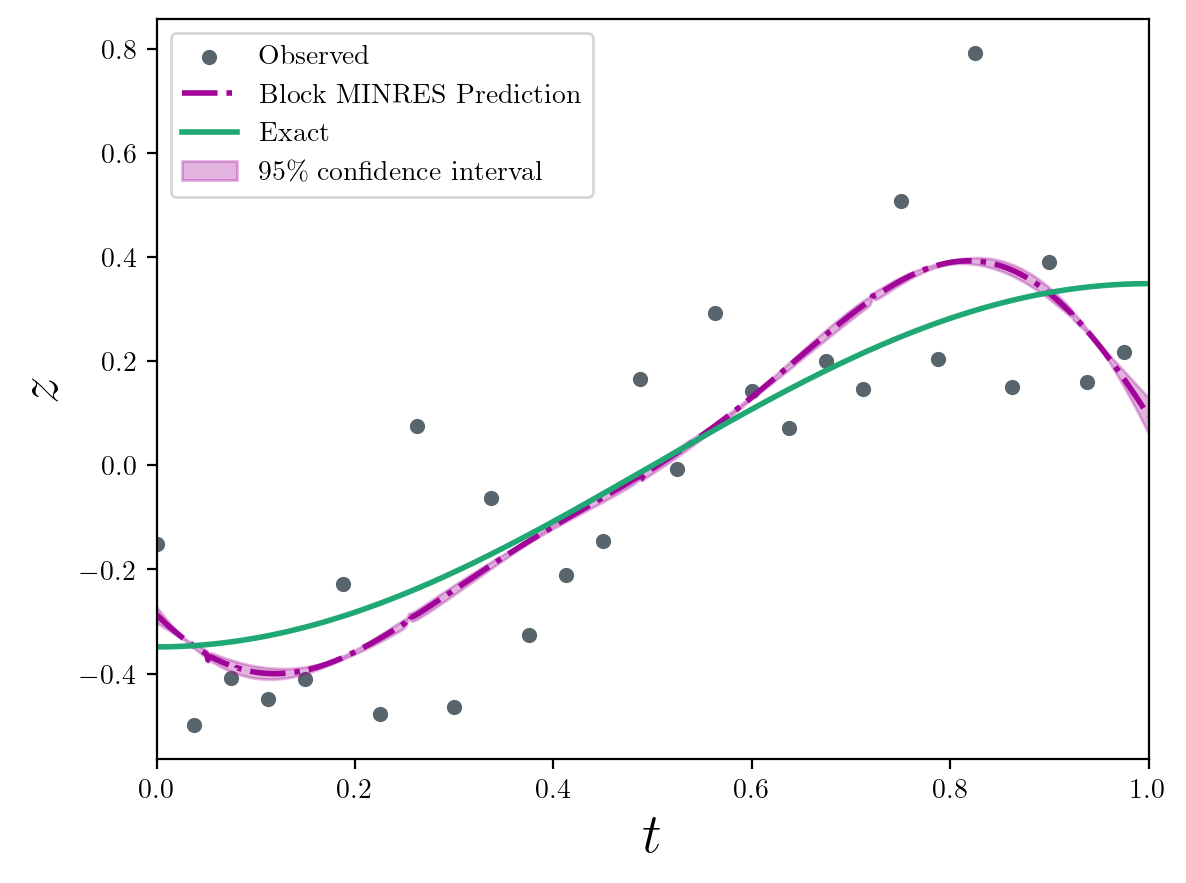

In [26]:
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
#plt.plot(t_pred, my_z_pred, linestyle='dashed', color = 'xkcd:carnation', linewidth='2', label='Direct Solve Prediction')
#plt.plot(t_pred, gs_z_pred, color='xkcd:cobalt', linestyle='dotted',linewidth='2', label='GSTools Prediction')
#plt.plot(t_pred, ifgt_z_pred, color='xkcd:pumpkin', linestyle='dashdot',linewidth='2', label='IFGT Prediction')
plt.plot(t_pred, bk_z_pred, color='xkcd:barney purple', linestyle='dashdot',linewidth='2', label='Block MINRES Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.fill_between(
    t_pred,
    bk_z_pred - 1.96*bk_std,
    bk_z_pred + 1.96*bk_std,
    alpha=0.3,
    label=r"95\% confidence interval",
    color='xkcd:barney purple',
)
plt.legend()
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.show()

So, block MINRES is fast and gives a pretty good mean, but the standard deviation is too narrow to be really useful. So, it's worth waiting a little longer to get the better error estimates we saw with method 1.  

### Method 5: SciKit-Learn's $\texttt{GaussianProcessRegressor}$

SciKit-Learn used Cholesky decomposition to solve the kriging system, and you can easily pass in a regularization parameter "alpha" 
(in their docs, they only identify as quantifying noise, but it is still the same thing as our $\gamma$ from method 1). So far, this seems pretty good: Cholesky should be faster than a direct solve. Of course, not every covariance function for a Gaussian random field gives rise to a kriging system with an SPD matrix, therefore Cholesky can't be used all the time. However, *most of the time* (including with the well-loved Gaussian RBF kernels), our matrix is SPD and Cholesky is the way to go!

Additionally, SciKit-Learn trains a covariance function much faster than GSTools, and the covariance function it spits out is better at explaining outliers. 

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=6e-2)
gaussian_process.fit(t_obs.reshape(-1,1), z_obs.reshape(-1,1))
gaussian_process.kernel_
# old method:  var=0.0759, len_scale=0.0321

0.285**2 * RBF(length_scale=0.352)

In [28]:
start=time.time()
skl_z_pred, skl_std = gaussian_process.predict(t_pred.reshape(-1,1), return_std=True)
end=time.time()
skl_runtime=end-start
print('Homemade direct solve runtime = % .3f' % my_runtime, 's')
print('GSTools runtime = %.3f' % gs_runtime, 's')
print('IFGT kriging runtime = %.3f' % ifgt_runtime, 's')
print('Block MINRES Runtime = %.3f' % bk_runtime, 's')
print('SKL runtime = %.4f' % skl_runtime, 's')

Homemade direct solve runtime =  0.006 s
GSTools runtime = 0.012 s
IFGT kriging runtime = 19.348 s
Block MINRES Runtime = 0.071 s
SKL runtime = 0.0052 s


So, even though it has to **retrain the kernel from scratch**, SciKit-Learn is even faster than block MINRES! Let's plot the estimator to check its quality. 

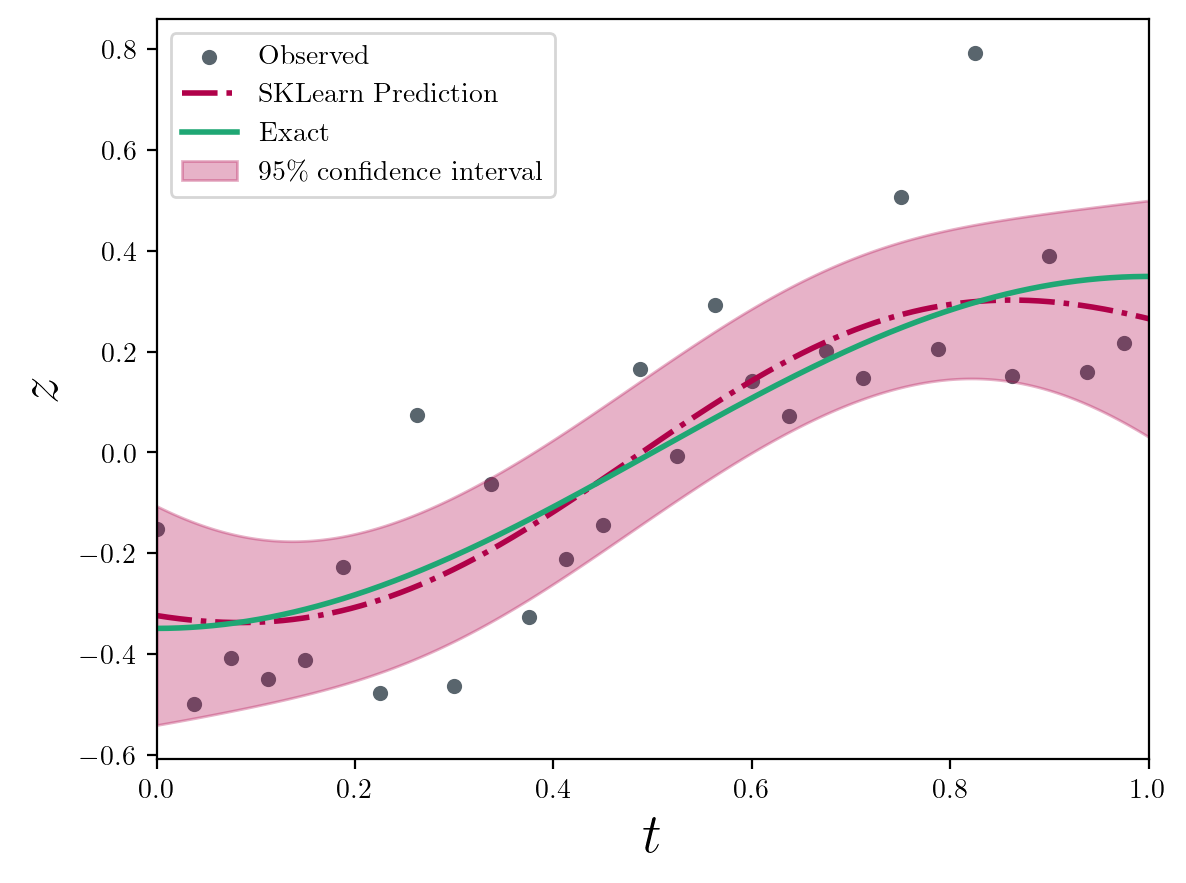

In [29]:
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.plot(t_pred, skl_z_pred, color='xkcd:raspberry', linestyle='dashdot',linewidth='2', label='SKLearn Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.fill_between(
    t_pred,
    skl_z_pred - 1.96*skl_std,
    skl_z_pred + 1.96*skl_std,
    alpha=0.3,
    label=r"95\% confidence interval",
    color='xkcd:raspberry',
)
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

The mean is about as good as method 1, but the error bars are a lot wider and therefore place more data in the $95%$ confidence interval. Taking this *and* speed into account, SciKit-Learn gives the best way to krige a time series I have yet found. 

### Dishonourable Mention: Parallelized Quadratic Programming

One might ask: why bother kriging with linear algebra when the linear algebra arises from a quadratic programming problem? Can't we just solve all the optimization problems in parallel and get better performance? 

The answer is "no", at least in the case of basic parallelization strategies like using joblib: it turns out such an approach is basically just a slower version of method 1. 

Homemade direct solve runtime =  0.006 s
GSTools runtime = 0.012 s
IFGT kriging runtime = 19.348 s
Block MINRES Runtime = 0.071 s
SKL runtime = 0.0052 s
QP runtime = 0.701 s


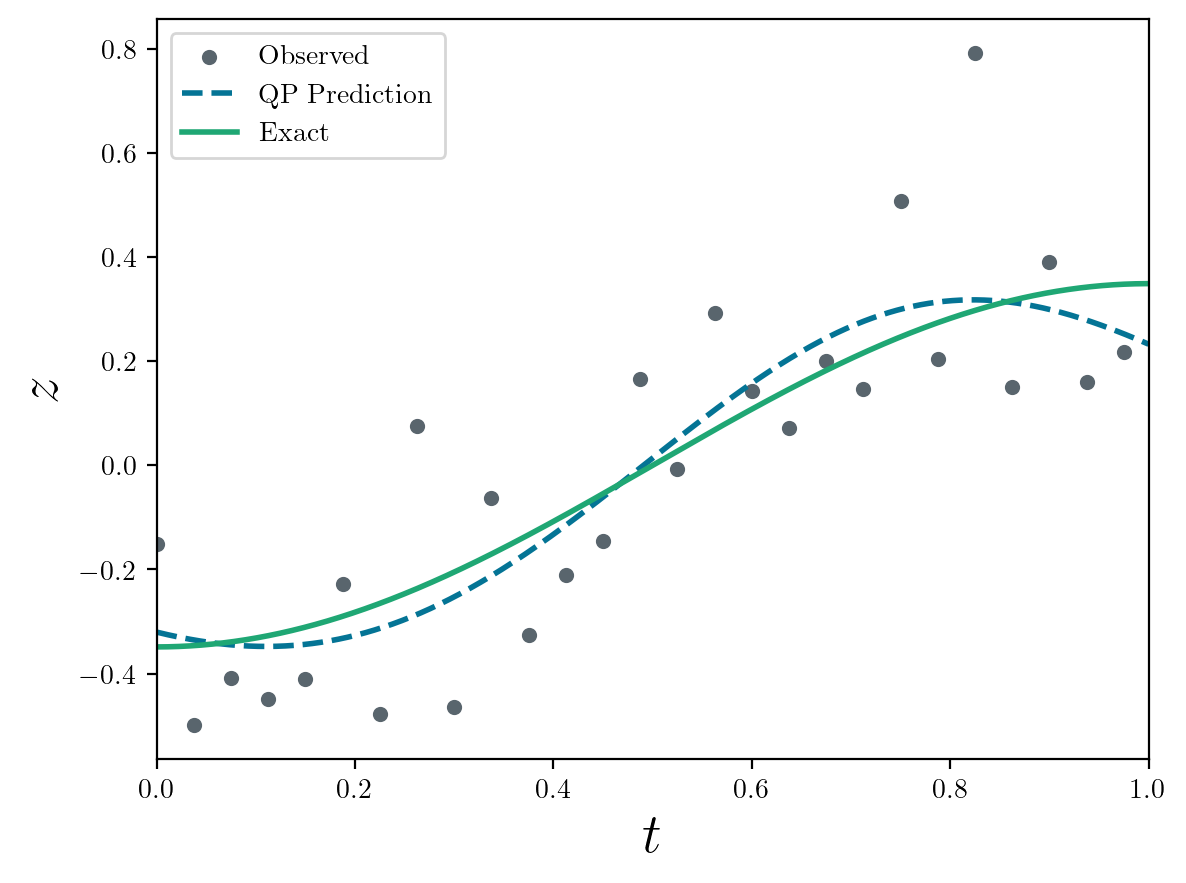

In [30]:
#"""
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

A = matrix(np.ones(n), (1,n))

c = matrix(1.)

Q = 2.*matrix(K[:-1,:-1]+gamma*np.eye(n), (n,n))

G = matrix(np.zeros((n,n)))

h = matrix(np.zeros(n))

def qp_predict(j):
    solvers.options['show_progress'] = False
    return np.dot(z_obs, solvers.qp(Q,  -2.*matrix(b[:-1,j]), G, h, A, c)['x'])

start=time.time()
qp_z_pred = joblib.Parallel(n_jobs=-1)(joblib.delayed(qp_predict)(j) for j in range(num_pts)) 
end=time.time()
qp_runtime=end-start

print('Homemade direct solve runtime = % .3f' % my_runtime, 's')
print('GSTools runtime = %.3f' % gs_runtime, 's')
print('IFGT kriging runtime = %.3f' % ifgt_runtime, 's')
print('Block MINRES Runtime = %.3f' % bk_runtime, 's')
print('SKL runtime = %.4f' % skl_runtime, 's')
print('QP runtime = %.3f' % qp_runtime ,'s')

plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.plot(t_pred, qp_z_pred, color='xkcd:sea blue', linestyle='--',linewidth='2', label='QP Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.legend()
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.show()
#"""